# **Explanatory Data Analysis**

### 0. Load the dataset

In [2]:
%load_ext autoreload
%autoreload 2
from utils.helpers import read_file
from utils.constants import Constant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
C = Constant()

### 1. TSLA News

In [3]:
tesla_news_path  = f"{C.raw_data_dir}TSLA_news.parquet"
tesla_news = read_file(tesla_news_path)

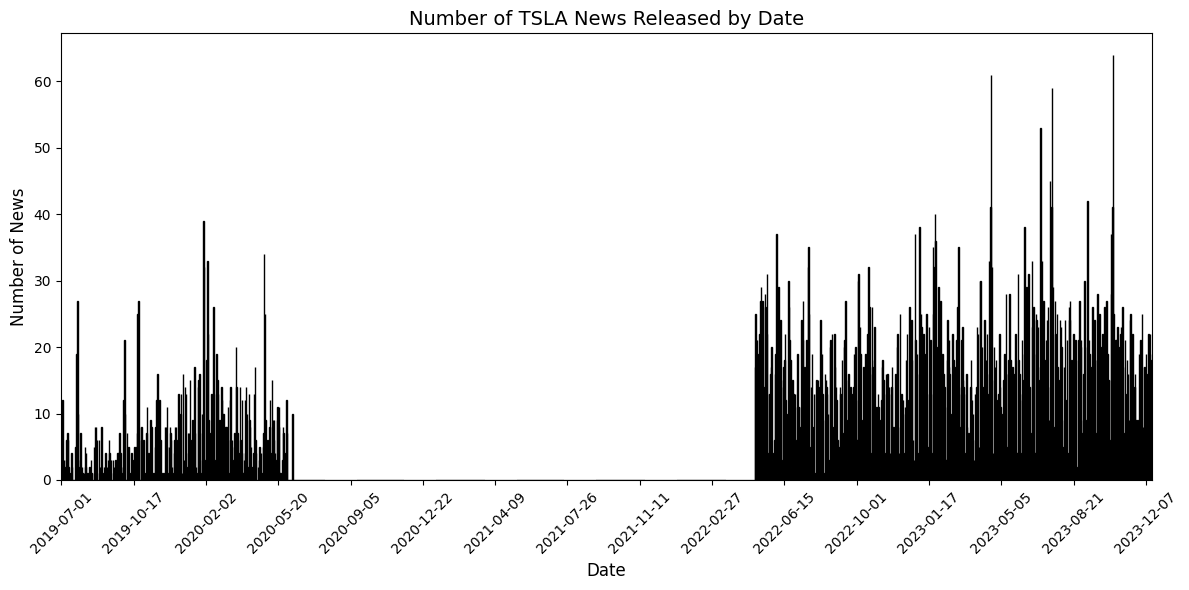

In [4]:
def vis_news_release_date(df,symbol):
    df['Date'] = pd.to_datetime(df['Date'])
    # Resample data to ensure consistency, focusing on daily article counts
    df_count_full = df.set_index('Date').resample('D').size()

    # Select evenly spaced 15 dates for xticks
    dates_to_plot = df_count_full.index[::max(len(df_count_full) // 15, 1)]

    # Plotting with adjusted xticks
    plt.figure(figsize=(12, 6))
    df_count_full.plot(kind='bar', color='skyblue', edgecolor='black', width=0.8)
    plt.title(f"Number of {symbol} News Released by Date", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Number of News", fontsize=12)
    plt.xticks(range(len(df_count_full)), df_count_full.index.date, rotation=45)
    plt.xticks(ticks=[df_count_full.index.get_loc(date) for date in dates_to_plot], labels=dates_to_plot.date, rotation=45)


    plt.tight_layout()
    plt.show()
    return df_count_full

df_count_full = vis_news_release_date(tesla_news,'TSLA')

In [5]:
cutoff_date = pd.Timestamp("2021-12-31")
max_date_smaller = df_count_full.index[(df_count_full.index < cutoff_date)&(df_count_full>0)].max()
min_date_bigger = df_count_full.index[(df_count_full.index > cutoff_date)&(df_count_full>0)].min()

print(f"The date range that has missing date starting from {max_date_smaller} to {min_date_bigger}")

The date range that has missing date starting from 2020-06-10 00:00:00 to 2022-05-02 00:00:00


From the plots, the dataset exhibits significant gaps in time coverage, as there are periods with no recorded news articles. This suggests that the data may be incomplete and not continuous over the full date range. Due to the limitation of the news dataset, this project will focus on the price performance starting from 2022-05-02 to 2023-12-07.

In [6]:
df_filtered = tesla_news[tesla_news['Date'] >= min_date_bigger]
df_filtered.head()

,Date,Stock_symbol,Article_title
0,2023-12-16 22:00:00,TSLA,Scotiabank's Mexico bet eyeing $1.6 trillion N...
1,2023-12-16 20:00:00,TSLA,Can the 'Magnificent Seven' Continue to Lead t...
2,2023-12-16 20:00:00,TSLA,"Notable ETF Outflow Detected - IWB, TSLA, LLY,..."
3,2023-12-16 20:00:00,TSLA,"Swedes support Tesla mechanics' strike, poll s..."
4,2023-12-16 20:00:00,TSLA,"Some Potential 2024 Winners Reside in QQQ, QQQM"


In [7]:
df_filtered["Time"] = df_filtered["Date"].dt.time
news_count_by_time = df_filtered.groupby("Time").size()

/var/folders/t9/x5knz49s7qj_dry4y1r799x00000gn/T/ipykernel_8149/2059734722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Time"] = df_filtered["Date"].dt.time


It's obvious that in this dataset, most of the timestamps of the news are released at midnight, which is another limitation from the TSLA news dataset. 

### 2. Crypto News

In [8]:
crypto_news_path  = f"{C.raw_data_dir}crypto_news.csv"

crypto_news = read_file(crypto_news_path).rename(columns={'date':'Date'})
crypto_news = crypto_news[crypto_news['subject']=='altcoin']

In [18]:
def vis_news_release(df, symbol):
    if pd.api.types.is_datetime64tz_dtype(df['Date']):
        df['Date'] = df['Date'].dt.tz_convert(None)
    # Ensure 'Date' column is datetime
    df['Date'] = pd.to_datetime(df['Date']).dt.ceil('min')
    df = df[df['Date'] >= pd.Timestamp("2022-05-02")]
    # Plot 1: Number of News Released by Date (Daily Counts)
    df_count_full = df.set_index('Date').resample('D').size()
    dates_to_plot = df_count_full.index[::max(len(df_count_full) // 15, 1)]

    # Plot 2: Number of News Released by Time of Day
    df['Time'] = df['Date'].dt.time
    news_count_by_time = df.groupby('Time').size()

    # Ensure all times from 00:00:00 to 23:59:59 are present
    full_range = pd.date_range("00:00:00", "23:59:59", freq="1s").time
    news_count_by_time = news_count_by_time.reindex(full_range, fill_value=0)
    filtered_xticks = [time for time in news_count_by_time.index if time.strftime("%H:%M:%S").endswith(":00:00")]

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(10,8))

    # Plot daily counts
    df_count_full.plot(
        kind='bar', color='skyblue', edgecolor='black', width=0.8, ax=axes[0]
    )
    axes[0].set_title(f"Number of {symbol} Released by Date", fontsize=16)
    axes[0].set_xlabel("Date", fontsize=12)
    axes[0].set_ylabel(f"Number of {symbol}", fontsize=14)
    axes[0].set_xticks(range(len(df_count_full)))
    axes[0].set_xticklabels(df_count_full.index.date, rotation=45, fontsize=12)
    axes[0].set_xticks(
        [df_count_full.index.get_loc(date) for date in dates_to_plot]
    )
    axes[0].set_xticklabels(dates_to_plot.date, rotation=45)

    # Plot time of day counts
    news_count_by_time.plot(
        kind='bar', color='skyblue', edgecolor='black', width=0.8, ax=axes[1]
    )
    axes[1].set_title(f"Number of {symbol} Released by Time", fontsize=16)
    axes[1].set_xlabel("Time", fontsize=12)
    axes[1].set_ylabel(f"Number of {symbol}", fontsize=14)
    axes[1].set_xticks(
        [news_count_by_time.index.get_loc(time) for time in filtered_xticks]
    )
    axes[1].set_xticklabels(
        [time.strftime("%H:%M:%S") for time in filtered_xticks], rotation=45, fontsize=12
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return df_count_full, news_count_by_time



/var/folders/t9/x5knz49s7qj_dry4y1r799x00000gn/T/ipykernel_8149/4256760844.py:2: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['Date']):
/var/folders/t9/x5knz49s7qj_dry4y1r799x00000gn/T/ipykernel_8149/4256760844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = df['Date'].dt.time


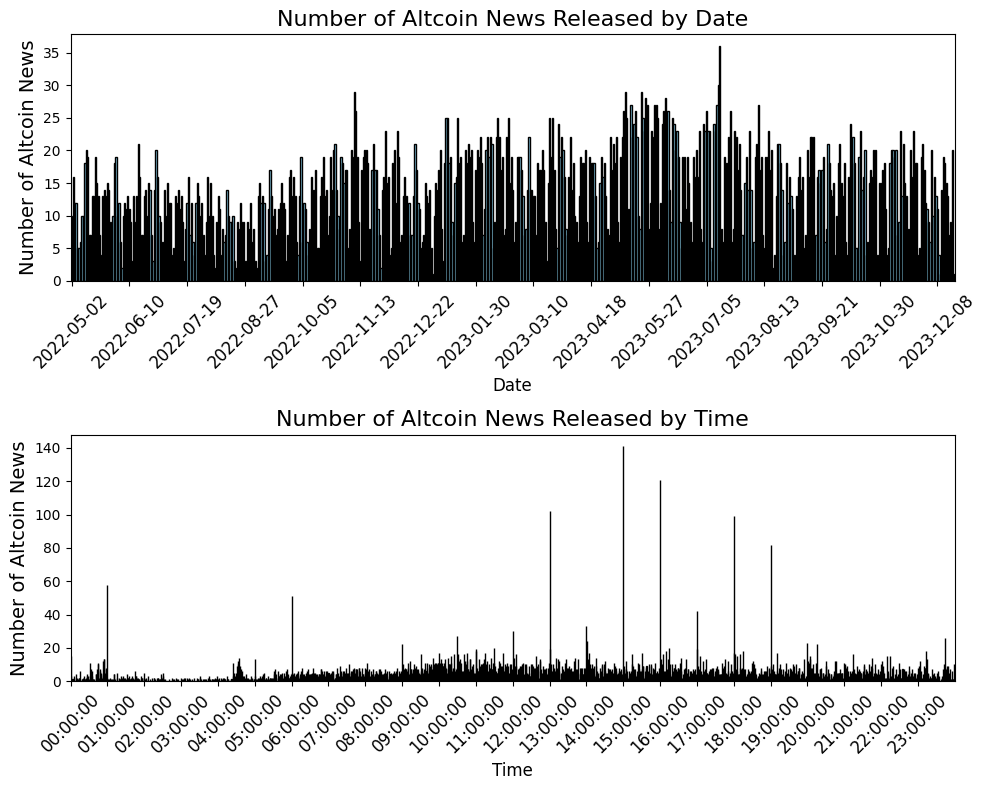

(Date
 2022-05-02    10
 2022-05-03    16
 2022-05-04    12
 2022-05-05    12
 2022-05-06     5
               ..
 2023-12-15    13
 2023-12-16     7
 2023-12-17     9
 2023-12-18    20
 2023-12-19     1
 Freq: D, Length: 597, dtype: int64,
 Time
 00:00:00    15
 00:00:01     0
 00:00:02     0
 00:00:03     0
 00:00:04     0
             ..
 23:59:55     0
 23:59:56     0
 23:59:57     0
 23:59:58     0
 23:59:59     0
 Length: 86400, dtype: int64)

In [19]:
vis_news_release(crypto_news, 'Altcoin News')

### 3. Elon Musk's Tweet

In [16]:
elon_musk_tweets_path = f"{C.raw_data_dir}elon_musk_tweets.csv"

elon_musk_tweets = read_file(elon_musk_tweets_path).rename(columns={'date':'Date'})
elon_musk_tweets

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,Date,text,hashtags,source,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240855,115,13503,True,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...,NaN,Twitter for iPhone,335,6542,False
1,1544377493263720450,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks",NaN,Twitter for iPhone,1451,30753,False
2,1544377130590552064,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,Twitter for iPhone,1284,28610,False
3,1544375575724400645,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:40:05+00:00,@ExplainThisBob This guy gets it,NaN,Twitter for iPhone,131,3640,False
4,1544375148605853699,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...,NaN,Twitter for iPhone,1191,23790,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5899,1665143503108677634,Elon Musk,NaN,NaN,2009-06-02 20:12:29+00:00,143325985,330,25655,False,2023-06-03 23:48:42+00:00,@JonErlichman He’s not wrong …,NaN,Twitter for iPhone,361,4791,False
5900,1665139144425631747,Elon Musk,NaN,NaN,2009-06-02 20:12:29+00:00,143325985,330,25655,False,2023-06-03 23:31:23+00:00,"@alifarhat79 Guys, I think I maybe took too mu...",NaN,Twitter for iPhone,1609,61964,False
5901,1665137204782419968,Elon Musk,NaN,NaN,2009-06-02 20:12:29+00:00,143325985,330,25655,False,2023-06-03 23:23:41+00:00,@sriramk Cool,NaN,Twitter for iPhone,46,879,False
5902,1665131126900285445,Elon Musk,NaN,NaN,2009-06-02 20:12:29+00:00,143325985,330,25655,False,2023-06-03 22:59:31+00:00,@cb_doge Time to complete the circle,NaN,Twitter for iPhone,898,12467,False


/var/folders/t9/x5knz49s7qj_dry4y1r799x00000gn/T/ipykernel_8149/4256760844.py:2: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['Date']):


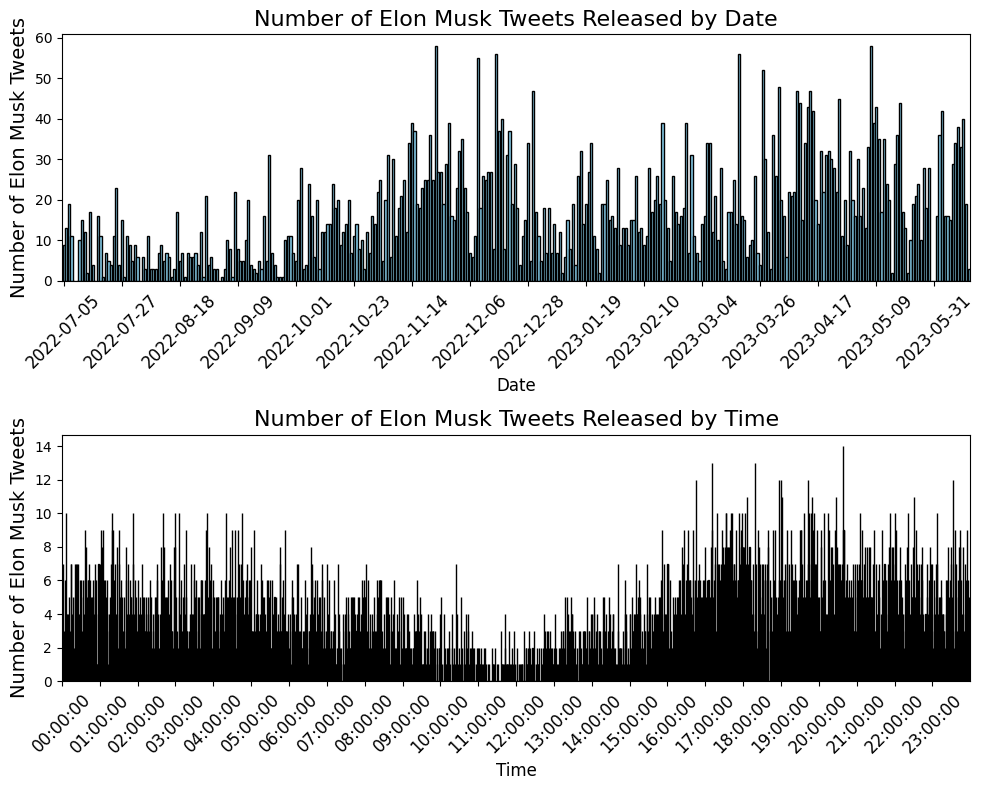

(Date
 2022-07-05     9
 2022-07-06    13
 2022-07-07    19
 2022-07-08    11
 2022-07-09     0
               ..
 2023-06-09    38
 2023-06-10    33
 2023-06-11    40
 2023-06-12    19
 2023-06-13     3
 Freq: D, Length: 344, dtype: int64,
 Time
 00:00:00    4
 00:00:01    0
 00:00:02    0
 00:00:03    0
 00:00:04    0
            ..
 23:59:55    0
 23:59:56    0
 23:59:57    0
 23:59:58    0
 23:59:59    0
 Length: 86400, dtype: int64)

In [20]:
vis_news_release(elon_musk_tweets, 'Elon Musk Tweets')

From the visualization, we can see that both the altcoin news and elon musk's tweets have clustering in some speical timepoints, and the throughout the entire day, the news or the tweets are posted constantly without much gaps, indicating a flow-like characteristic.